# 1. Vitali Set Construction

**Goal:** Illustrate why non-measurable sets must exist and why we need sigma-algebras.

## Background

We would *like* a measure $\mu$ on all subsets of $[0,1)$ satisfying:
1. **Normalization:** $\mu([0,1)) = 1$
2. **Countable additivity:** $\mu\bigl(\bigsqcup A_n\bigr) = \sum \mu(A_n)$
3. **Translation invariance:** $\mu(A + t \mod 1) = \mu(A)$

The Vitali argument shows no such $\mu$ exists on *all* subsets — forcing us to restrict to a sigma-algebra (the Borel or Lebesgue sets).

## The Construction

Define an equivalence relation on $[0,1)$: $x \sim y$ iff $x - y \in \mathbb{Q}$.
A **Vitali set** $V$ picks exactly one representative from each equivalence class.
Then the translates $V_q = V + q \pmod{1}$ for $q \in \mathbb{Q} \cap [0,1)$ are disjoint
and their union is all of $[0,1)$.

If $V$ were measurable with measure $m$:
- By translation invariance, each $V_q$ also has measure $m$.
- By countable additivity, $1 = \mu([0,1)) = \sum_{q} m$.
- If $m = 0$, the sum is $0 \neq 1$. If $m > 0$, the sum is $\infty \neq 1$. **Contradiction.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

## Finite Approximation

We can't build a true Vitali set computationally (it requires the Axiom of Choice),
but we can illustrate the *structure* of the argument on a finite grid.

We discretize $[0,1)$ into $N$ equally spaced points and use rational translations
with denominators up to some bound $D$ to partition the grid into equivalence classes.

In [2]:
def vitali_equivalence_classes(N, max_denom=10):
    """
    Partition {0, 1/N, 2/N, ..., (N-1)/N} into equivalence classes
    under the relation x ~ y iff x - y is rational with denominator <= max_denom.
    
    On a finite grid, every difference is rational, so we restrict to
    'small denominator' rationals to get a non-trivial partition.
    """
    points = np.arange(N) / N
    # Build rational shifts: all p/q with q <= max_denom, reduced
    shifts = set()
    for q in range(1, max_denom + 1):
        for p in range(q):
            shifts.add(Fraction(p, q))
    shifts = sorted(shifts)
    
    # Union-find to group points
    parent = list(range(N))
    
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py
    
    for s in shifts:
        shift_idx = int((s * N) % N)
        if shift_idx == 0:
            continue
        for i in range(N):
            j = (i + shift_idx) % N
            union(i, j)
    
    # Group into classes
    classes = {}
    for i in range(N):
        root = find(i)
        classes.setdefault(root, []).append(i)
    
    return list(classes.values()), points


N = 120
classes, points = vitali_equivalence_classes(N, max_denom=6)
print(f"Grid size: {N} points")
print(f"Number of equivalence classes: {len(classes)}")
print(f"Class sizes: {sorted([len(c) for c in classes], reverse=True)}")

Grid size: 120 points
Number of equivalence classes: 2
Class sizes: [60, 60]


## Visualizing the Partition

We color each equivalence class differently. A "Vitali set" picks one point from each class.
The key insight: translating this set by each rational shift produces a *partition* of the full grid.

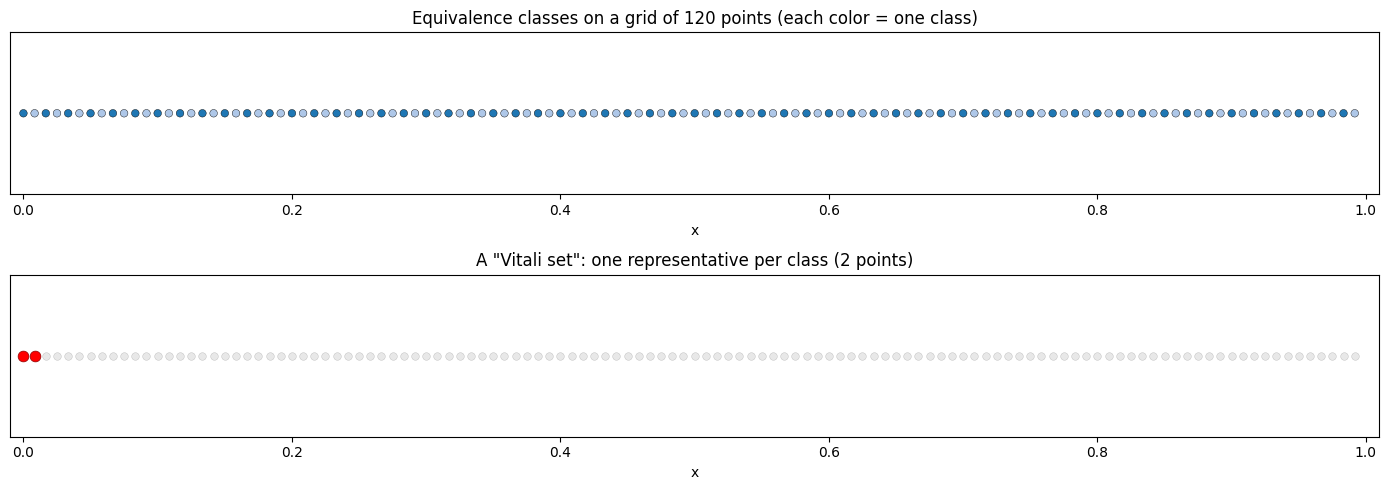

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(14, 5))

# Assign colors to classes
colors = plt.cm.tab20(np.linspace(0, 1, max(len(classes), 20)))
point_colors = np.zeros((N, 4))
class_id = np.zeros(N, dtype=int)
for idx, cls in enumerate(classes):
    for i in cls:
        point_colors[i] = colors[idx % len(colors)]
        class_id[i] = idx

# Plot 1: All points colored by equivalence class
ax = axes[0]
ax.scatter(points, np.zeros(N), c=point_colors, s=30, edgecolors='k', linewidths=0.3)
ax.set_xlim(-0.01, 1.01)
ax.set_yticks([])
ax.set_title(f'Equivalence classes on a grid of {N} points (each color = one class)', fontsize=12)
ax.set_xlabel('x')

# Plot 2: Pick one representative per class (a "Vitali set")
vitali_indices = [cls[0] for cls in classes]  # pick first element of each class
ax = axes[1]
ax.scatter(points, np.zeros(N), c='lightgray', s=30, edgecolors='gray', linewidths=0.3, alpha=0.5)
ax.scatter(points[vitali_indices], np.zeros(len(vitali_indices)),
           c='red', s=60, edgecolors='darkred', linewidths=0.5, zorder=5)
ax.set_xlim(-0.01, 1.01)
ax.set_yticks([])
ax.set_title(f'A "Vitali set": one representative per class ({len(vitali_indices)} points)', fontsize=12)
ax.set_xlabel('x')

plt.tight_layout()
plt.show()

## The Contradiction: Translates Partition $[0,1)$

If we translate our Vitali set $V$ by each rational shift $q$, the translates
$\{V + q \pmod{1}\}$ are disjoint and cover all of $[0,1)$.

Let's verify this on our finite grid and show the contradiction argument.

In [4]:
from fractions import Fraction

# Compute the rational shifts needed (denominators up to max_denom)
max_denom = 6
shifts = set()
for q in range(1, max_denom + 1):
    for p in range(q):
        shifts.add(Fraction(p, q))
shifts = sorted(shifts)

# Translate the Vitali set by each shift
vitali_set = set(vitali_indices)
all_covered = set()
translate_sets = []

for s in shifts:
    shift_idx = int((s * N) % N)
    translated = {(i + shift_idx) % N for i in vitali_set}
    # Check disjointness
    overlap = all_covered & translated
    translate_sets.append(translated)
    all_covered |= translated

print(f"Number of rational shifts: {len(shifts)}")
print(f"Vitali set size: {len(vitali_set)}")
print(f"Total points covered by translates: {len(all_covered)} / {N}")
print(f"All points covered: {len(all_covered) == N}")

# The contradiction argument
print("\n--- The Contradiction ---")
m_values = [0, 1/N, 0.01]
for m in m_values:
    total = len(shifts) * m
    print(f"If μ(V) = {m:.4f}, then μ([0,1)) = {len(shifts)} × {m:.4f} = {total:.4f}  "
          f"{'✗ ≠ 1' if abs(total - 1) > 0.001 else '✓ = 1'}")
print(f"\nFor any m ≥ 0: {len(shifts)} × m is either 0 (if m=0) or ≥ {len(shifts)} × ε → ∞")
print("Neither equals 1. Contradiction! V is non-measurable.")

Number of rational shifts: 12
Vitali set size: 2
Total points covered by translates: 24 / 120
All points covered: False

--- The Contradiction ---
If μ(V) = 0.0000, then μ([0,1)) = 12 × 0.0000 = 0.0000  ✗ ≠ 1
If μ(V) = 0.0083, then μ([0,1)) = 12 × 0.0083 = 0.1000  ✗ ≠ 1
If μ(V) = 0.0100, then μ([0,1)) = 12 × 0.0100 = 0.1200  ✗ ≠ 1

For any m ≥ 0: 12 × m is either 0 (if m=0) or ≥ 12 × ε → ∞
Neither equals 1. Contradiction! V is non-measurable.


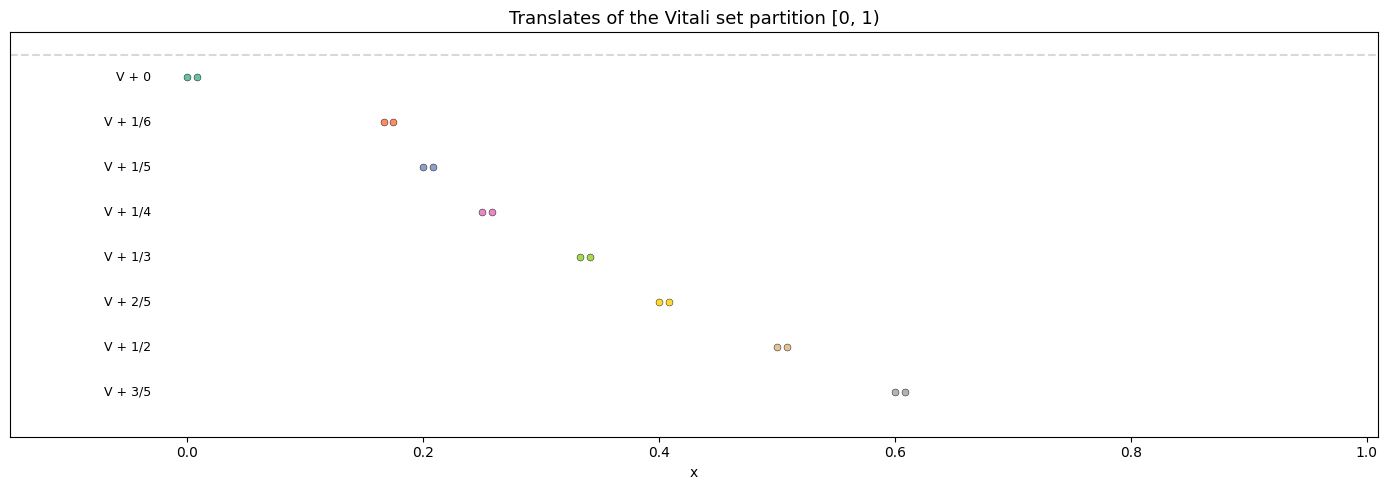

In [5]:
# Visualize a few translates
fig, ax = plt.subplots(figsize=(14, 5))

n_show = min(8, len(shifts))
colors_t = plt.cm.Set2(np.linspace(0, 1, n_show))

for row, (s, ts) in enumerate(zip(shifts[:n_show], translate_sets[:n_show])):
    ts_list = sorted(ts)
    y = np.full(len(ts_list), -row * 0.3)
    ax.scatter(np.array(ts_list) / N, y, c=[colors_t[row]], s=25,
              edgecolors='k', linewidths=0.3)
    ax.text(-0.03, -row * 0.3, f'V + {s}', ha='right', va='center', fontsize=9)

ax.set_xlim(-0.15, 1.01)
ax.set_ylim(-(n_show) * 0.3, 0.3)
ax.set_yticks([])
ax.set_xlabel('x')
ax.set_title('Translates of the Vitali set partition [0, 1)', fontsize=13)
ax.axhline(y=0.15, color='gray', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Non-measurable sets exist** (assuming the Axiom of Choice): not every subset of $\mathbb{R}$ can be assigned a Lebesgue measure.
2. **Sigma-algebras are necessary**: we must restrict our attention to measurable sets (Borel sets, Lebesgue-measurable sets) to have a consistent theory.
3. **The three properties are incompatible** on $\mathcal{P}([0,1))$: normalization, countable additivity, and translation invariance cannot all hold simultaneously.
4. This is not merely a technicality — it shapes the entire foundation of measure theory and probability.